In [27]:
# environment: Paperspace Quadro P6000 GPU
import numpy as np 
import pandas as pd 
import os 
import tensorflow as tf
import keras # run pip install keras==2.3 beforehand for compatability 
from keras import Input, Model 
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Dropout, AlphaDropout, MaxPooling2D, AveragePooling2D, BatchNormalization, Concatenate, Flatten, Reshape, Add
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# Read in data

In [2]:
train_path = './storage/modified_mnist_dataset/train.csv'  
test_path = './storage/modified_mnist_dataset/test.csv' 
submission_path = './storage/modified_mnist_dataset/submission.csv' 

In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path) 
submission = pd.read_csv(submission_path) 

# Preprocessing data

The objective of this competition is to predict the digit given an image with overlapped digit and letter as the train dataset 

In [4]:
# checking how the train data looks like 
train.head(2)

,id,digit,letter,0,1,2,3,4,5,6,...,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,...,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,...,0,3,0,1,4,1,4,2,1,2


In [5]:
# checking how the test data looks like 
test.head(2)

,id,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,...,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,...,0,3,2,4,2,4,2,2,1,2


In [6]:
# checking how the submission file looks like 
submission.head()

,id,digit
0,2049,0
1,2050,0
2,2051,0
3,2052,0
4,2053,0


In [7]:
# convert types of digit and letter columns to categorical 
train.iloc[:,1] = pd.Categorical(train.iloc[:,1])
train.iloc[:,2] = pd.Categorical(train.iloc[:,2]) 
test.iloc[:,1] = pd.Categorical(test.iloc[:,1])

In [8]:
# define and re-format train and test data 
x_train = train.iloc[:,3:].values.reshape(-1,28,28,1).astype(np.float32) 
y_train = train.iloc[:,1].values
train_letters = train.iloc[:,2].values

x_test = test.iloc[:,2:].values.reshape(-1,28,28,1).astype(np.float32) 
test_letters = test.iloc[:,1].values

In [9]:
# normalize x_train and x_test 
# convert y_train, train_letters, test_letters to categorical 
x_train = x_train/255.0 
x_test = x_test/255.0 
y_train = np.asarray(y_train)
y_train = to_categorical(y_train, num_classes = 10) 

In [10]:
train_letters_numeric = [] 
test_letters_numeric = [] 
for letter in train_letters: 
    train_letters_numeric.append(ord(letter) - ord("A"))
for letter in test_letters: 
    test_letters_numeric.append(ord(letter) - ord("A")) 
    
train_letters_numeric = np.asarray(train_letters_numeric) 
test_letters_numeric = np.asarray(test_letters_numeric) 

train_letters_numeric = to_categorical(train_letters_numeric, num_classes = 26) 
test_letters_numeric = to_categorical(test_letters_numeric, num_classes = 26)

In [11]:
x_train.shape, y_train.shape, x_test.shape, train_letters_numeric.shape, test_letters_numeric.shape

((2048, 28, 28, 1), (2048, 10), (20480, 28, 28, 1), (2048, 26), (20480, 26))

# Visualizing data

The image below shows an example of digit 6 hidden by the letter V. 

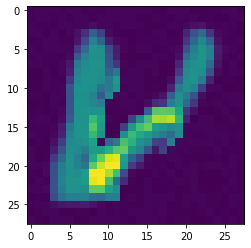

In [12]:
plt.imshow(x_train[2043].reshape(28,28))

# Constructing model and training

In [33]:
def build_model(): 
    inputs = Input((28,28,1)) 
    letter_data = Input((26,)) 
    
    conv1 = Conv2D(32, 3, padding = 'same', activation = 'selu', kernel_initializer = 'lecun_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 3, padding = 'same', activation = 'selu', kernel_initializer = 'lecun_normal')(conv1) 
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, 5, padding = 'same', activation = 'selu', kernel_initializer = 'lecun_normal')(conv1)
    conv1 = BatchNormalization()(conv1)  
    conv1 = AlphaDropout(0.4)(conv1) 
    
    conv2 = Conv2D(64, 3, padding = 'same', activation = 'selu', kernel_initializer = 'lecun_normal')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 3, padding = 'same', activation = 'selu', kernel_initializer = 'lecun_normal')(conv2) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, 5, padding = 'same', activation = 'selu', kernel_initializer = 'lecun_normal')(conv2)
    conv2 = BatchNormalization()(conv2)  
    conv2 = AlphaDropout(0.4)(conv2) 
    conv2 = Flatten()(conv2)
    
    # concatenate letter data  
    outputs = Concatenate()([conv2, letter_data])
    outputs = Dense(128, activation = 'selu', kernel_initializer = 'lecun_normal')(outputs) 
    outputs = BatchNormalization()(outputs) 
    outputs = AlphaDropout(0.4)(outputs)
    outputs = Dense(128, activation = 'selu', kernel_initializer = 'lecun_normal')(outputs) 
    outputs = BatchNormalization()(outputs) 
    outputs = AlphaDropout(0.4)(outputs)
    outputs = Dense(10, activation = 'softmax')(outputs)
    
    model = Model(inputs = [inputs,letter_data], outputs = outputs) 
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 
    return model 

def build_resnet():
    inputs = Input((28,28,1)) 
    letter_data = Input((26,)) 
    
    conv1 = Conv2D(64, 5, padding = 'same', activation = 'selu', kernel_initializer = 'lecun_normal')(inputs)
    bn = BatchNormalization()(conv1)
    for i in range(10): 
        conv2 = Conv2D(64, 5, padding = 'same', activation = 'selu', kernel_initializer = 'lecun_normal')(bn)
        concat = Concatenate()([conv1,conv2])  
        bn = BatchNormalization()(concat)
    
    conv3 = Conv2D(32, 3, padding = 'same', activation = 'selu', kernel_initializer = 'lecun_normal')(bn)
    bn = BatchNormalization()(conv3)
    for i in range(10):
        conv4 = Conv2D(32, 3, padding = 'same', activation = 'selu', kernel_initializer = 'lecun_normal')(bn)
        concat = Concatenate()([conv3,conv4]) 
        bn = BatchNormalization()(concat) 
    
    flattened = Flatten()(bn)
    dense1 = Dense(256, activation = 'selu', kernel_initializer = 'lecun_normal')(flattened)
    bn = BatchNormalization()(dense1)
    for i in range(3): 
        dense2 = Dense(256, activation = 'selu', kernel_initializer = 'lecun_normal')(bn)
        added = Add()([dense1, dense2]) 
        bn = BatchNormalization()(added) 
    
    outputs = Dense(10, activation = 'softmax')(bn) 
    model = Model(inputs = inputs, outputs = outputs) 
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

    return model


In [31]:
# codeblock to delete files in model directory - for experimentation 
files = [os.path.join('./storage/modified_mnist_base_cnn/',x) for x in os.listdir('./storage/modified_mnist_base_cnn/')] 
for file in files:  
    if 'epoch' in file: 
        os.remove(file)

In [35]:
# define data generator 
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1,  
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

model_path = './storage/modified_mnist_base_cnn/epoch_{epoch:03d}_val_{val_loss:.3f}_acc_{val_accuracy:.3f}.h5' 
# adjust learning rate for loss on plateau 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
# checkpoint saves file with best accuracy 
checkpoint = ModelCheckpoint(filepath=model_path,monitor='val_accuracy',verbose=1,save_best_only=True)
# early stopping checkpoint to speed up training time 
early_stopping = EarlyStopping(monitor='val_accuracy',patience=15)

# perform a 9:1 train-validation split 
k = int(0.9 * len(x_train))
x_train_set = x_train[:k] 
y_train_set = y_train[:k] 
letter_train_set = train_letters_numeric[:k] 

x_val_set = x_train[k:]
y_val_set = y_train[k:] 
letter_val_set = train_letters_numeric[k:] 

model = build_resnet() 

history = model.fit_generator(
    datagen.flow(x_train_set, y_train_set, batch_size = 32, shuffle = True),
    epochs = 300, 
    steps_per_epoch = x_train_set.shape[0]//32,
    verbose = 1, 
    validation_data = (x_val_set, y_val_set), 
    callbacks=[learning_rate_reduction, checkpoint, early_stopping]
)


Epoch 1/300
57/57 [==============================] - 24s 430ms/step - loss: 2.8173 - accuracy: 0.1966 - val_loss: 6.9972 - val_accuracy: 0.0976

Epoch 00001: val_accuracy improved from -inf to 0.09756, saving model to ./storage/modified_mnist_base_cnn/epoch_001_val_6.997_acc_0.098.h5
Epoch 2/300
57/57 [==============================] - 8s 146ms/step - loss: 1.8913 - accuracy: 0.3462 - val_loss: 14.6331 - val_accuracy: 0.0976

Epoch 00002: val_accuracy did not improve from 0.09756
Epoch 3/300
57/57 [==============================] - 8s 147ms/step - loss: 1.6525 - accuracy: 0.4130 - val_loss: 10.2823 - val_accuracy: 0.1707

Epoch 00003: val_accuracy improved from 0.09756 to 0.17073, saving model to ./storage/modified_mnist_base_cnn/epoch_003_val_10.282_acc_0.171.h5
Epoch 4/300
57/57 [==============================] - 8s 147ms/step - loss: 1.5156 - accuracy: 0.4848 - val_loss: 7.3121 - val_accuracy: 0.1317

Epoch 00004: val_accuracy did not improve from 0.17073
Epoch 5/300
57/57 [========

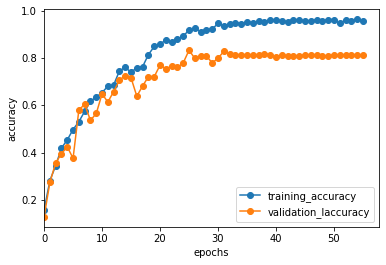

In [52]:
# graph the training and validation losses 
plt.plot(history.epoch, history.history['accuracy'],'-o',label='training_accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], '-o',label='validation_laccuracy')
plt.legend() 
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [53]:
# load best model for prediction 
best_model_path = './storage/modified_mnist_base_cnn/epoch_026_val_0.515_acc_0.834.h5'
best_model = load_model(best_model_path) 
y_pred = best_model.predict([x_test, test_letters_numeric])  

In [57]:
# interpret the result from y_pred
result_array = []  
for pred in y_pred: 
    result_array.append(np.argmax(pred)) 
result_array = np.asarray(result_array) 

In [60]:
# store prediction results to submission file
submission['digit'] = result_array
submission.head()

,id,digit
0,2049,6
1,2050,3
2,2051,8
3,2052,0
4,2053,3


In [61]:
# save submission file 
submission.to_csv('./storage/modified_mnist_base_cnn.csv',index = False)